![banner](../img/cdips_2017_logo.png)

# Grid Search Cross-Validation for Neural Networks

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import scripts.load_data as load

import seaborn as sns
sns.set(font_scale=1)

%matplotlib inline

In [2]:
import sklearn.decomposition
import sklearn.random_projection
import sklearn.neural_network
from sklearn.model_selection import train_test_split

In [3]:
X, y  = load.load_training_spectra()

The results of the grid search are in a pandas DataFrame.

A few notes about the results:

- In attempt to match the [Kaggle competition](https://www.kaggle.com/c/afsis-soil-properties#evaluation),
we used a different evaluation method than the $R^2$,
which is the default for scikit-learn.
The evaluation method is
mean columnwise root mean squared error (MCRMSE)
-- the average, across the five targets, of our root mean squared error.
Though the two are closely related,
there's not an exact transformation between the two.
- GridSearchCV uses a "score",
rather than an "error" --
a score goes up when you do better,
whereas an error goes down.
To match this,
we ran the GridSearch with negative MCRMSE as the
"score".
The cells below load the data and then multiply the score
values by `-1` so that they become MCRMSE values.

In [4]:
grid_search_results = pd.read_csv('../data/model_params/GridSearch_07262017.csv',index_col=0)

In [5]:
columns_to_keep = [column for column in grid_search_results.columns
                                            if not column.endswith('_time')]

grid_search_results = grid_search_results[columns_to_keep]

In [6]:
columns_to_flip = [column for column in grid_search_results.columns
                                          if column.endswith('_score')
                                              and not (column.startswith('std')
                                                      or column.startswith('rank'))]

grid_search_results[columns_to_flip] = grid_search_results[columns_to_flip]*-1

In [7]:
columns_to_rename = [column for column in grid_search_results.columns
                                            if column.endswith('_score')]

renamed_columns = [column.rstrip('score')+'error' for column in columns_to_rename]
grid_search_results[renamed_columns] = grid_search_results[columns_to_rename]
grid_search_results = grid_search_results.drop(columns_to_rename,axis=1)

First, let's look at the basic descriptive statistics of the test and train error.

In [8]:
columns_to_describe = ['mean_test_error','mean_train_error']

grid_search_results[columns_to_describe].describe()

,mean_test_error,mean_train_error
count,2.592000e+03,2.592000e+03
mean,4.675100e+06,3.737600e+06
std,2.290322e+08,1.821058e+08
min,4.548547e-01,5.784026e-02
25%,5.407330e-01,5.074934e-01
50%,8.389147e-01,8.241527e-01
75%,1.072892e+00,1.054324e+00
max,1.165126e+10,9.261679e+09


The distribution appears to be very skew,
with the maximum being 11 orders of magnitude above the minimum
and 10 orders of magnitude larger than the 75th percentile.

These bad performers will make it difficult to visualize
the remaining data, so we drop them
by `query`ing for models that have reasonable performance.

In [9]:
filtered_results = grid_search_results.query('mean_test_error<1')
filtered_results = filtered_results.query('mean_train_error<1')

Now we can visualize our results.

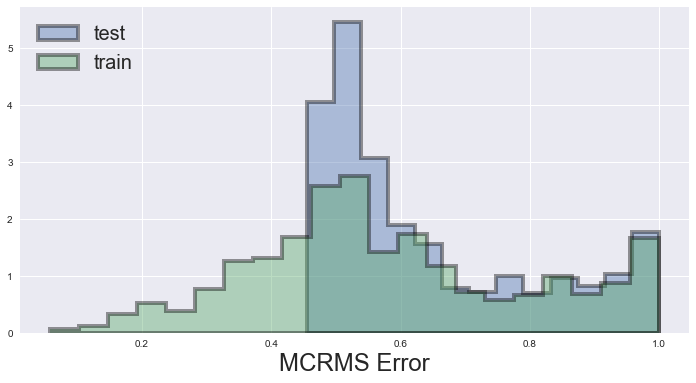

In [10]:
plt.figure(figsize=(12,6))
sns.distplot(filtered_results.mean_test_error, kde=False,
             hist_kws={'normed':True,
                       'edgecolor':'k',
                       'linewidth':4,
                      'histtype':'stepfilled'},
            label='test');

sns.distplot(filtered_results.mean_train_error, kde=False,
             hist_kws={'normed':True,
                       'edgecolor':'k',
                       'linewidth':4,
                      'histtype':'stepfilled'},
            label='train');
plt.legend(fontsize=20)
plt.xlabel('MCRMS Error',fontsize=24);

Interestingly, it appears that there's a hard limit to our performance on the test set,
while performance on the training set can reach up to nearly perfect.

Though it's difficult to compare precisely,
since the test set used in the Kaggle competition 
is now unavailable,
this limit to our performance appears close to
the best performance possible --
within a few hundredths, at least.

In addition to the test error,
the difference between the test and train error
is also an important criterion for model selection.
This is called the *generalization error*.

Below, we calculate it and plot its distribution.

In [11]:
for split_index in ['0','1','2']:
    test_error = filtered_results['split'+split_index+'_test_error']
    train_error = filtered_results['split'+split_index+'_train_error']
    filtered_results['generalization_error'+split_index] = test_error-train_error
    
filtered_results['mean_generalization_error'] =  1/3*(filtered_results['generalization_error0'] +
                                                filtered_results['generalization_error1'] +
                                                filtered_results['generalization_error2'])

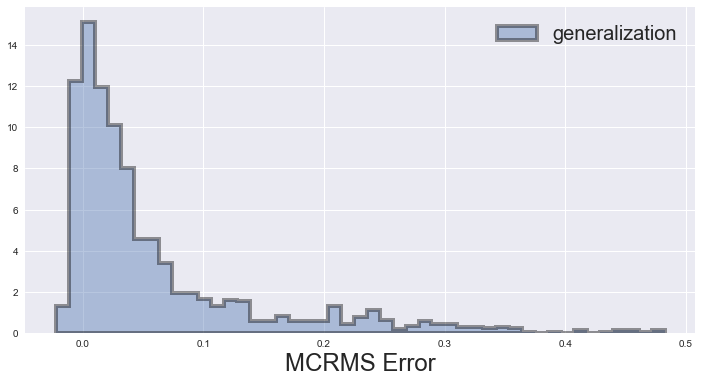

In [12]:
plt.figure(figsize=(12,6))
sns.distplot(filtered_results.mean_generalization_error, kde=False,
             hist_kws={'normed':True,
                       'edgecolor':'k',
                       'linewidth':4,
                      'histtype':'stepfilled'},
            label='generalization');

plt.legend(fontsize=20)
plt.xlabel('MCRMS Error',fontsize=24);

Generalization performance is very spread out,
with most models generalizing very well,
but some models generalizing very poorly.

In order to pick the best model,
we need to look at the relationship between generalization error
and test error.

The cell below uses seaborn's `pairplot`
to plot the pairwise relationships between training error,
test error, and generalization error.

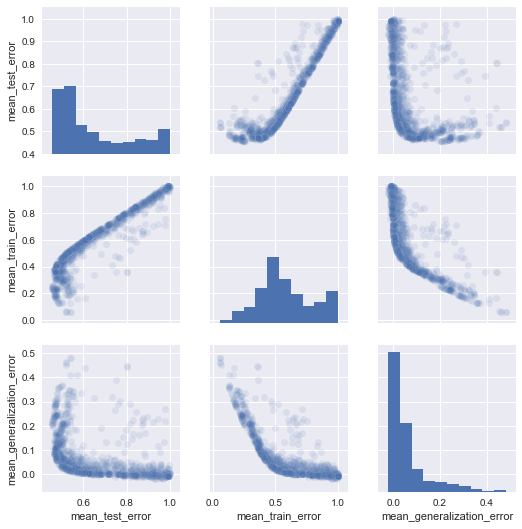

In [13]:
columns_to_plot = ["mean_test_error","mean_train_error","mean_generalization_error"]

sns.pairplot(filtered_results,vars=columns_to_plot,
                plot_kws={'alpha':0.1,},);

Training and test error are approximately linearly related, as might be expected.

The most important plot here is in the top-right corner,
and indicates the relationship between generalization error and test error.

The cell below plots just this relationship using `jointplot`.
To get a clearer sense of the distribution,
we plot it with a
[kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation),
which is a sort of "smoothed histogram", loosely speaking.

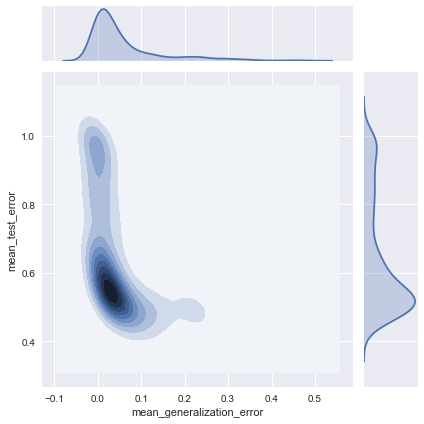

In [14]:
sns.jointplot(x='mean_generalization_error',y='mean_test_error',
             data=filtered_results,
             stat_func=None,
             kind='kde');

The best models are in the bottom-left of this chart --
they have low test error and low generalization error.

It appears that the majority of models tested fall in a single cluster,
with more variability along the test error axis
than along the generalization error axis.

With a gross sense of the performance in hand,
we now proceed to looking at the parameters of the best performers.

## Top Performers on Test Set

First, let's take a look at the top performers on the test set.

We can sort by the `rank_test_error` column
to pull out the best-performing hyperparameter settings.

In [15]:
filtered_results = filtered_results.sort_values(by='rank_test_error')
filtered_results.head(25)

,param_activation,param_alpha,param_batch_size,param_beta_1,param_beta_2,param_early_stopping,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_tol,...,split1_test_error,split1_train_error,split2_test_error,split2_train_error,std_test_error,std_train_error,generalization_error0,generalization_error1,generalization_error2,mean_generalization_error
41,relu,0.0001,16,0.90,0.990,False,100,0.0001,10000,1.000000e-16,...,0.450593,0.253905,0.479622,0.228775,0.018704,0.010387,0.196521,0.196689,0.250847,0.214685
113,relu,0.0001,16,0.95,0.990,False,100,0.0001,10000,1.000000e-16,...,0.464164,0.275693,0.477577,0.222931,0.021722,0.022307,0.164687,0.188471,0.254646,0.202601
137,relu,0.0001,16,0.95,0.999,False,100,0.0001,10000,1.000000e-16,...,0.461241,0.256388,0.479281,0.203258,0.021097,0.022983,0.182397,0.204853,0.276022,0.221091
257,relu,0.0001,32,0.90,0.990,False,100,0.0001,10000,1.000000e-16,...,0.456055,0.243241,0.478661,0.225477,0.017709,0.022651,0.155425,0.212814,0.253183,0.207141
281,relu,0.0001,32,0.90,0.999,False,100,0.0001,10000,1.000000e-16,...,0.461874,0.281741,0.481737,0.233655,0.022458,0.022187,0.191634,0.180133,0.248082,0.206616
64,relu,0.0001,16,0.90,0.999,False,100,0.0001,10000,1.000000e-64,...,0.460769,0.293535,0.476674,0.201822,0.015813,0.038139,0.175073,0.167234,0.274852,0.205720
256,relu,0.0001,32,0.90,0.990,False,100,0.0001,10000,1.000000e-64,...,0.470126,0.297022,0.483943,0.240019,0.026087,0.024307,0.169404,0.173104,0.243924,0.195477
16,relu,0.0001,16,0.90,0.900,False,100,0.0001,10000,1.000000e-64,...,0.466460,0.243777,0.473414,0.220203,0.015664,0.009857,0.200773,0.222683,0.253211,0.225555
280,relu,0.0001,32,0.90,0.999,False,100,0.0001,10000,1.000000e-64,...,0.464265,0.272148,0.478827,0.198829,0.017959,0.029970,0.196953,0.192117,0.279999,0.223023
136,relu,0.0001,16,0.95,0.999,False,100,0.0001,10000,1.000000e-64,...,0.456919,0.230647,0.484443,0.202587,0.018661,0.013996,0.205409,0.226272,0.281856,0.237846


A few things pop out:
for example,
early stopping is unpopular
and rectified linear units (`relu`s)
seem to outperform logistic units.

We can get a closer look by
plotting the distribution of test performances for each hyperparameter.

In [16]:
best_results = filtered_results.head(100)

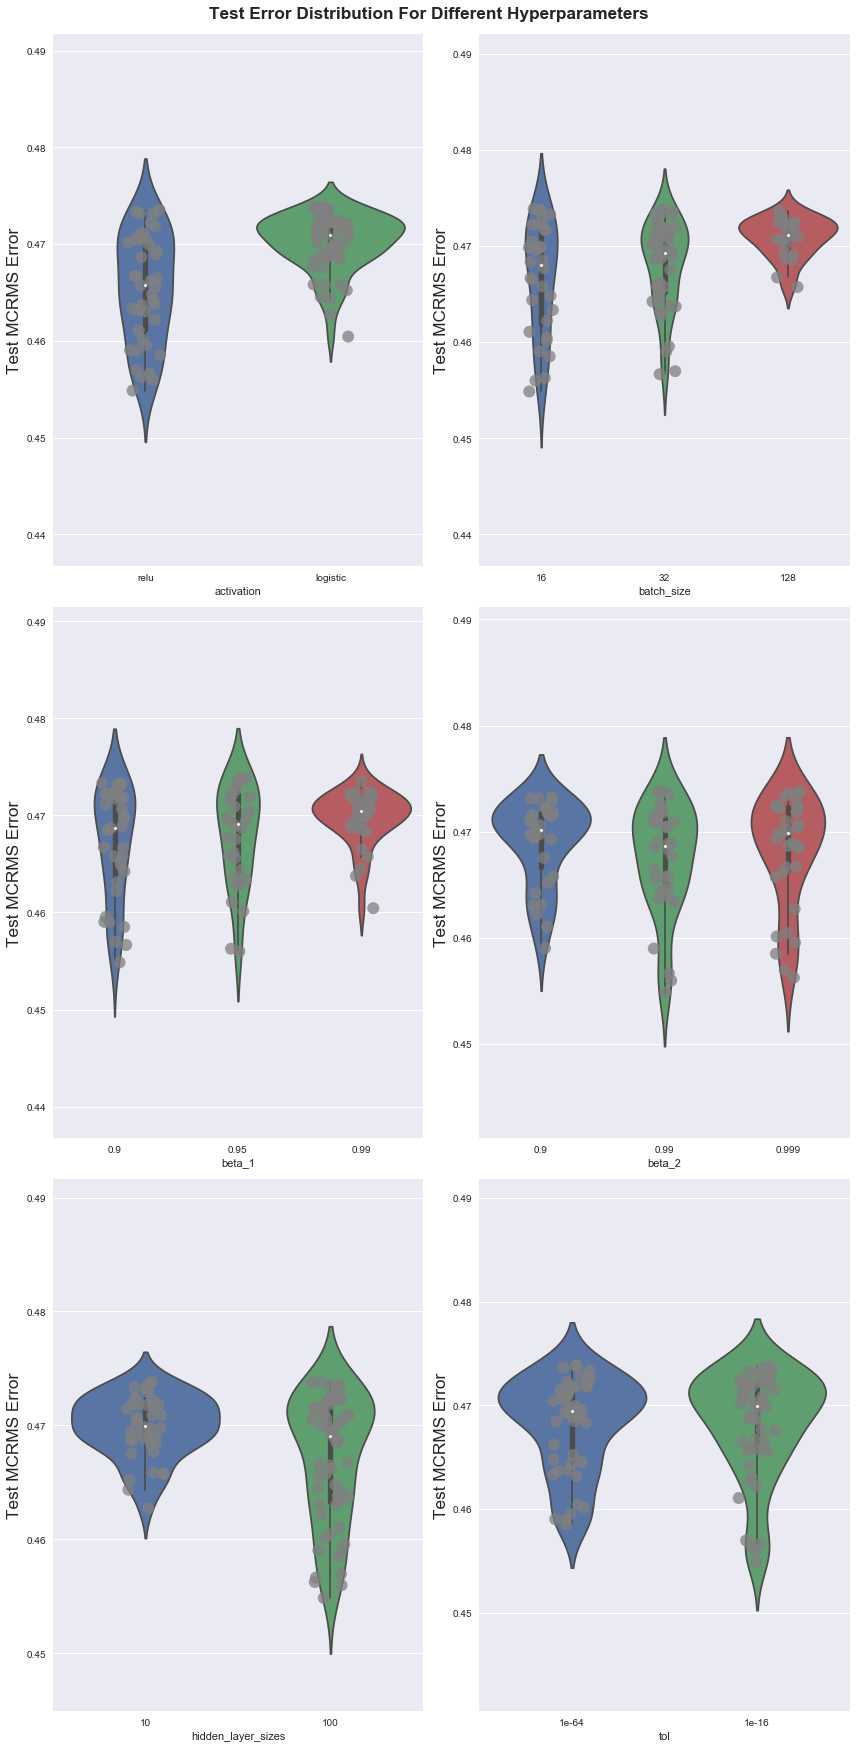

In [17]:
columns_to_describe = [column for column in best_results.columns
                                          if column.startswith('param_')
                                          and not (column.endswith('_max_iter')
                                                  or column.endswith('_learning_rate_init')
                                                  or column.endswith('_alpha')
                                                  or column.endswith('_early_stopping'))
                                              ]                        

def make_error_plot(dataframe, error_column, error_name, columns_to_describe):
    plt.figure(figsize=(12,24))
    cols = 2
    rows = np.ceil(len(columns_to_describe)/2)
    for idx,column in enumerate(columns_to_describe):
        plt.subplot(rows,cols,idx+1)
        sns.stripplot(x=dataframe[column],y=dataframe[error_column],
                      jitter=True,size=12,alpha=0.75,color='gray'
                     )
        sns.violinplot(x=dataframe[column],y=dataframe[error_column],
                      )
        plt.ylabel(error_name +' MCRMS Error',fontsize='xx-large')
        plt.xlabel(column[6:])
    
    plt.tight_layout()
    plt.suptitle(error_name + ' Error Distribution For Different Hyperparameters',y=1.01,
                fontweight='bold',fontsize='xx-large');
    
make_error_plot(best_results, 'mean_test_error', 'Test', columns_to_describe)

For best test performance,
we want rectified linear units
with a batch size smaller than 128,
100 nodes in the hidden layer,
and no early stopping.

Interestingly, these are essentially
the same parameters that were discovered
by the hand-tuning procedure.

## Networks with Lowest Generalization Error from Best Performers

In [18]:
best_results = best_results.sort_values(by='mean_generalization_error')
best_results[columns_to_describe+['mean_generalization_error','mean_test_error','mean_train_error']].head(10)

,param_activation,param_batch_size,param_beta_1,param_beta_2,param_hidden_layer_sizes,param_tol,mean_generalization_error,mean_test_error,mean_train_error
1409,logistic,16,0.95,0.990,100,1.000000e-16,0.065490,0.473753,0.408327
1624,logistic,32,0.95,0.990,100,1.000000e-64,0.067090,0.473829,0.406801
1649,logistic,32,0.95,0.999,100,1.000000e-16,0.068502,0.473601,0.405156
1577,logistic,32,0.90,0.999,100,1.000000e-16,0.069476,0.473337,0.403921
1408,logistic,16,0.95,0.990,100,1.000000e-64,0.071069,0.472652,0.401643
1625,logistic,32,0.95,0.990,100,1.000000e-16,0.073665,0.472089,0.398484
1601,logistic,32,0.95,0.900,100,1.000000e-16,0.074270,0.471480,0.397271
1533,logistic,32,0.90,0.900,10,1.000000e-16,0.079100,0.469741,0.390694
1316,logistic,16,0.90,0.900,10,1.000000e-64,0.079150,0.471714,0.392620
1341,logistic,16,0.90,0.990,10,1.000000e-16,0.080053,0.472195,0.392194


Very different patterns arise for the generalization error
than for the test error!
For example, logistic units seem to be better,
and batch size doesn't seem to be as important.

Plotting the distribution of the generalization error confirms these trends.

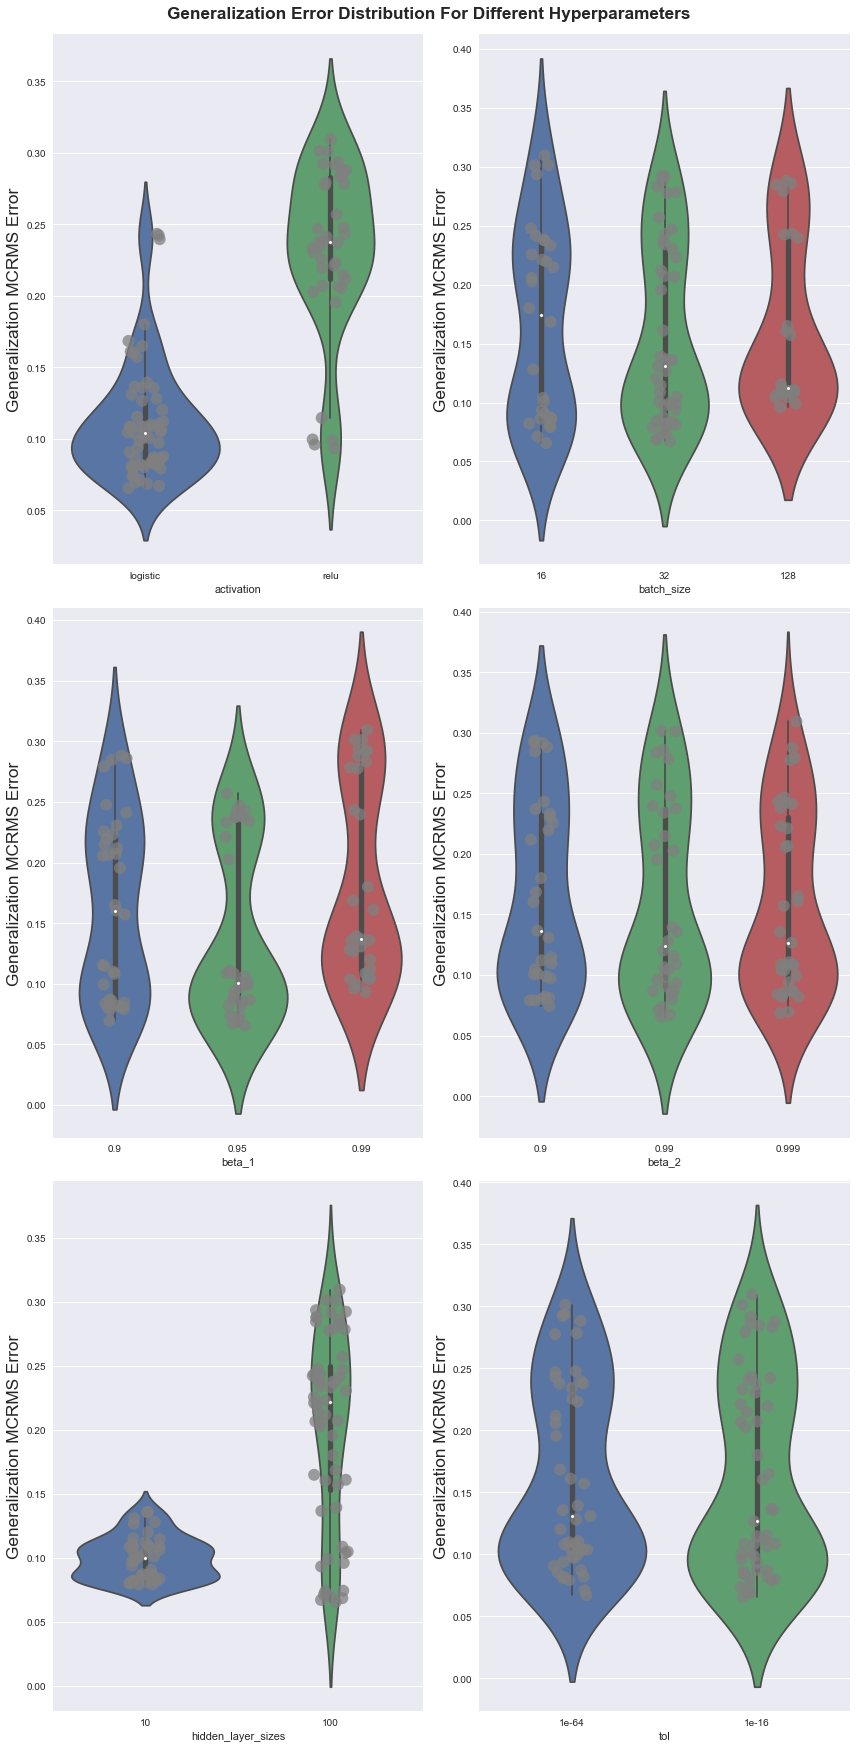

In [19]:
columns_to_describe = [column for column in best_results.columns
                                          if column.startswith('param_')
                                          and not (column.endswith('_max_iter')
                                                  or column.endswith('_learning_rate_init')
                                                  or column.endswith('_alpha')
                                                  or column.endswith('_early_stopping'))
                                              ]    

make_error_plot(best_results, 'mean_generalization_error', 'Generalization', columns_to_describe)

So which hyperparameter setting do we choose?

Over-fitting is a serious issue for machine learning methods
applied in the real world.
Importantly,
the method of separating a data set collected at one time
into a training and a test set tends to underestimate
what the generalization error will be
when the model is deployed on totally new data.

Heuristically, a large generalization error on the
internally split training and test set
is a sign that the generalization error
on a totally novel set will be even larger.
This would motivate us to select the hyperparameter settings
that minimize generalization error while still
keeping the test error low.